# Testing `mlrun.handler` Decorator

Notebook for testing the functionalities of the `mlrun.handler` decorator:
* Setting labels
* Parsing inputs - converting `mlrun.DataItem`s to their configured / type hinted type.
* Logging outputs - logging the returning function values to MLRun according to the configured / default artifact type.

Tests are separated into the following:
1. Setting labels
2. Logging outputs
3. Parsing inputs
4. Raising errors
5. Supporting class methods

All tests are running in 3 ways:
1. Without MLRun to see the decorator was transparent .
2. With MLRun locally.
3. With MLRun remotly as a job.

## General Configurations

In [1]:
# Image versions: scikit-learn~=1.0
# Test is set to install latest to make sure we are always up-to-date with the latest releases.
!pip install matplotlib plotly scikit-learn

In [2]:
import os
import sys
import tempfile
import zipfile

import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import mlrun

> 2023-02-13 00:13:54,861 [warning] Failed resolving version info. Ignoring and using defaults
> 2023-02-13 00:13:57,154 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}


In [3]:
# Path to the functions code:
FUNCTIONS_SCRIPT = os.path.abspath("./functions.py")

# Load all functions to call locally:
sys.path.append(FUNCTIONS_SCRIPT)
from functions import *

In [4]:
# Create the project:
project = mlrun.get_or_create_project(name="mlrun-handler-tests", context="./", user_project=True)

# Create the function out of the script:
mlrun_function = project.set_function(FUNCTIONS_SCRIPT, name="my-function", kind="job", image="mlrun/mlrun")

> 2023-02-13 00:14:12,519 [info] loaded project mlrun-handler-tests from ./ and saved in MLRun DB


## 1. Setting Labels

### 1.1. Set labels

Run the `set_labels` function to see the wrapper is setting the required labels.

In [5]:
def test_set_labels_without_mlrun():
    returned_result = set_labels(24)
    assert returned_result == 1

    returned_result = set_labels(20, 18)
    assert returned_result == 2

    returned_result = set_labels(arg1=24)
    assert returned_result == 1

    returned_result = set_labels(arg1=20, arg2=18)
    assert returned_result == 2


def test_set_labels_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="set_labels",
        params={"arg1": 24},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.metadata.labels)

    # Assertion:
    assert run_object.metadata.labels["a"] == "1"
    assert run_object.metadata.labels["b"] == "a test"
    assert run_object.metadata.labels["c"] == "[1, 2, 3]"

In [6]:
test_set_labels_without_mlrun()
test_set_labels_with_mlrun(local=True)
test_set_labels_with_mlrun(local=False)

> 2023-02-13 00:14:17,660 [info] starting run my-function-set_labels uid=0c962553376d4fdb852d5fc0b989f93e DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...b989f93e,0,Feb 13 00:14:17,completed,my-function-set_labels,"v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98ja=1b=a testc=[1, 2, 3]",,arg1=24,return=1,


> 2023-02-13 00:14:17,930 [info] run executed, status=completed
> 2023-02-13 00:14:17,931 [info] {'v3io_user': 'guyl', 'kind': '', 'owner': 'guyl', 'host': 'jupyter-guyl-65dfdbf79-tm98j', 'a': '1', 'b': 'a test', 'c': '[1, 2, 3]'}
> 2023-02-13 00:14:17,954 [info] starting run my-function-set_labels uid=d5d37fafe6ef406e9cd4cdbb4f0ab349 DB=http://mlrun-api:8080
> 2023-02-13 00:14:18,147 [info] Job is running in the background, pod: my-function-set-labels-cgbwt
> 2023-02-13 00:14:22,118 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:14:23,737 [info] To track results use the CLI: {'info_cmd': 'mlrun get run d5d37fafe6ef406e9cd4cdbb4f0ab349 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs d5d37fafe6ef406e9cd4cdbb4f0ab349 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...4f0ab349,0,Feb 13 00:14:22,completed,my-function-set_labels,"v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-set-labels-cgbwta=1b=a testc=[1, 2, 3]",,arg1=24,return=1,


> 2023-02-13 00:14:24,358 [info] run executed, status=completed
> 2023-02-13 00:14:24,358 [info] {'v3io_user': 'guyl', 'kind': 'job', 'owner': 'guyl', 'mlrun/client_version': '0.0.0+unstable', 'mlrun/client_python_version': '3.7.6', 'host': 'my-function-set-labels-cgbwt', 'a': '1', 'b': 'a test', 'c': '[1, 2, 3]'}


### 1.2. Set Labels from Function and Wrapper

Run the `set_labels_from_function_and_wrapper` function to see the wrapper is setting the required labels without interrupting to the ones set via the context by the user.

In [7]:
def test_set_labels_from_function_and_wrapper_without_mlrun():
    returned_result = set_labels_from_function_and_wrapper()
    assert returned_result is None


def test_set_labels_from_function_and_wrapper_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="set_labels_from_function_and_wrapper",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.metadata.labels)

    # Assertion:
    assert run_object.metadata.labels["context_label"] == "1"
    assert run_object.metadata.labels["wrapper_label"] == "2"

In [8]:
test_set_labels_from_function_and_wrapper_without_mlrun()
test_set_labels_from_function_and_wrapper_with_mlrun(local=True)
test_set_labels_from_function_and_wrapper_with_mlrun(local=False)

> 2023-02-13 00:14:24,583 [info] starting run my-function-set_labels_from_function_and_wrapper uid=74eda61d74b140a0909aa870dc212eda DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...dc212eda,0,Feb 13 00:14:24,completed,my-function-set_labels_from_function_and_wrapper,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98jcontext_label=1wrapper_label=2,,,,


> 2023-02-13 00:14:25,140 [info] run executed, status=completed
> 2023-02-13 00:14:25,141 [info] {'v3io_user': 'guyl', 'kind': '', 'owner': 'guyl', 'host': 'jupyter-guyl-65dfdbf79-tm98j', 'context_label': '1', 'wrapper_label': '2'}
> 2023-02-13 00:14:25,164 [info] starting run my-function-set_labels_from_function_and_wrapper uid=5438aac04eb04a6584320e47c38c96a2 DB=http://mlrun-api:8080
> 2023-02-13 00:14:25,454 [info] Job is running in the background, pod: my-function-set-labels-from-function-and-wrapper-6wfwg
> 2023-02-13 00:14:29,366 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:14:30,742 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 5438aac04eb04a6584320e47c38c96a2 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 5438aac04eb04a6584320e47c3

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...c38c96a2,0,Feb 13 00:14:29,completed,my-function-set_labels_from_function_and_wrapper,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-set-labels-from-function-and-wrapper-6wfwgcontext_label=1wrapper_label=2,,,,


> 2023-02-13 00:14:31,667 [info] run executed, status=completed
> 2023-02-13 00:14:31,667 [info] {'v3io_user': 'guyl', 'kind': 'job', 'owner': 'guyl', 'mlrun/client_version': '0.0.0+unstable', 'mlrun/client_python_version': '3.7.6', 'host': 'my-function-set-labels-from-function-and-wrapper-6wfwg', 'context_label': '1', 'wrapper_label': '2'}


## 2. Logging Outputs

### 2.1. Log Dataset

Run the `log_dataset` function to see the wrapper is logging the returned values as datasets artifacts.

In [9]:
def test_log_dataset_without_mlrun():
    my_array, my_df, my_dict, my_list = log_dataset()
    assert isinstance(my_array, np.ndarray)
    assert isinstance(my_df, pd.DataFrame)
    assert isinstance(my_dict, dict)
    assert isinstance(my_list, list)


def test_log_dataset_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 4  # my_array, my_df, my_dict, my_list
    assert run_object.artifact("my_array").as_df().shape == (10, 20)
    assert run_object.artifact("my_df").as_df().shape == (20, 10)
    assert run_object.artifact("my_dict").as_df().shape == (4, 2)
    assert run_object.artifact("my_list").as_df().shape == (3, 1)

In [10]:
test_log_dataset_without_mlrun()
test_log_dataset_with_mlrun(local=True)
test_log_dataset_with_mlrun(local=False)

> 2023-02-13 00:14:31,756 [info] starting run my-function-log_dataset uid=e148dbb918c84c37b0dd4045a90653cc DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...a90653cc,0,Feb 13 00:14:31,completed,my-function-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:14:32,857 [info] run executed, status=completed
> 2023-02-13 00:14:32,858 [info] {'my_array': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_array:e148dbb918c84c37b0dd4045a90653cc', 'my_df': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_df:e148dbb918c84c37b0dd4045a90653cc', 'my_dict': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_dict:e148dbb918c84c37b0dd4045a90653cc', 'my_list': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_list:e148dbb918c84c37b0dd4045a90653cc'}
> 2023-02-13 00:14:33,045 [info] starting run my-function-log_dataset uid=07f82f92d8ca48029f9215b3587eab01 DB=http://mlrun-api:8080
> 2023-02-13 00:14:33,443 [info] Job is running in the background, pod: my-function-log-dataset-zcfgj
> 2023-02-13 00:14:37,334 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with und

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...587eab01,0,Feb 13 00:14:37,completed,my-function-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-dataset-zcfgj,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:14:42,736 [info] run executed, status=completed
> 2023-02-13 00:14:42,737 [info] {'my_array': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_array:07f82f92d8ca48029f9215b3587eab01', 'my_df': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_df:07f82f92d8ca48029f9215b3587eab01', 'my_dict': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_dict:07f82f92d8ca48029f9215b3587eab01', 'my_list': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_dataset_my_list:07f82f92d8ca48029f9215b3587eab01'}


### 2.2. Log Directory

Run the `log_directory` function to see the wrapper is logging the directory as a zip file.

In [11]:
def test_log_directory_without_mlrun():
    temp_dir = tempfile.TemporaryDirectory()
    my_dir = log_directory(temp_dir.name)
    assert isinstance(my_dir, str)
    temp_dir.cleanup()


def test_log_directory_with_mlrun(local: bool):
    # Run the function:
    output_path = tempfile.TemporaryDirectory()
    run_object = mlrun_function.run(
        handler="log_directory",
        params={"path": output_path.name},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_dir
    my_dir_zip = run_object.artifact("my_dir").local()
    my_dir = os.path.join(output_path.name, "extract_here")
    with zipfile.ZipFile(my_dir_zip, "r") as zip_ref:
        zip_ref.extractall(my_dir)
    my_dir_contents = os.listdir(my_dir)
    assert len(my_dir_contents) == 3
    assert "a.txt" in my_dir_contents
    assert "b.txt" in my_dir_contents
    assert "c.txt" in my_dir_contents
    
    # Clear the output path:
    output_path.cleanup()

In [12]:
test_log_directory_without_mlrun()
test_log_directory_with_mlrun(local=True)
test_log_directory_with_mlrun(local=False)

> 2023-02-13 00:14:43,093 [info] starting run my-function-log_directory uid=42a5f442fe6944b6b16dedad15c00a08 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...15c00a08,0,Feb 13 00:14:43,completed,my-function-log_directory,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,path=/tmp/tmpbtnbdwvp,,my_dir


> 2023-02-13 00:14:43,425 [info] run executed, status=completed
> 2023-02-13 00:14:43,426 [info] {'my_dir': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_directory/0/my_dir.zip'}
> 2023-02-13 00:14:43,427 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_directory/0/my_dir.zip to local temp file
> 2023-02-13 00:14:43,462 [info] starting run my-function-log_directory uid=cd9e829a46454929afdb01bf198b54eb DB=http://mlrun-api:8080
> 2023-02-13 00:14:43,635 [info] Job is running in the background, pod: my-function-log-directory-jpshr
> 2023-02-13 00:14:47,536 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:14:49,160 [info] To track results use the CLI: {'info_cmd': 'mlrun get run cd9e829a46454929afdb01bf198b54eb -

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...198b54eb,0,Feb 13 00:14:47,completed,my-function-log_directory,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-directory-jpshr,,path=/tmp/tmpa6u007j7,,my_dir


> 2023-02-13 00:14:49,882 [info] run executed, status=completed
> 2023-02-13 00:14:49,882 [info] {'my_dir': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_directory/0/my_dir.zip'}
> 2023-02-13 00:14:49,883 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_directory/0/my_dir.zip to local temp file


### 2.3. Log File

Run the `log_file` function to see the wrapper is logging the file.

In [13]:
def test_log_file_without_mlrun():
    temp_dir = tempfile.TemporaryDirectory()
    my_file = log_file(temp_dir.name)
    assert isinstance(my_file, str)
    temp_dir.cleanup()


def test_log_file_with_mlrun(local: bool):
    # Run the function:
    output_path = tempfile.TemporaryDirectory()
    run_object = mlrun_function.run(
        handler="log_file",
        params={"path": output_path.name},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_file
    with open(run_object.artifact("my_file").local(), "r") as text_file:
        assert text_file.read() == "MLRun decorator test."
    
    # Clear the output path:
    output_path.cleanup()

In [14]:
test_log_file_without_mlrun()
test_log_file_with_mlrun(local=True)
test_log_file_with_mlrun(local=False)

> 2023-02-13 00:14:49,979 [info] starting run my-function-log_file uid=498e8c417bbd4588a53ae24f5c14eb2b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...5c14eb2b,0,Feb 13 00:14:50,completed,my-function-log_file,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,path=/tmp/tmpjo8yck8s,,my_file


> 2023-02-13 00:14:50,297 [info] run executed, status=completed
> 2023-02-13 00:14:50,297 [info] {'my_file': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_file/0/my_file.txt'}
> 2023-02-13 00:14:50,298 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_file/0/my_file.txt to local temp file
> 2023-02-13 00:14:50,331 [info] starting run my-function-log_file uid=63cd55ab597643a6a997953310cedf78 DB=http://mlrun-api:8080
> 2023-02-13 00:14:50,515 [info] Job is running in the background, pod: my-function-log-file-hsclz
> 2023-02-13 00:14:54,428 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:14:56,164 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 63cd55ab597643a6a997953310cedf78 -p mlrun-handler-t

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...10cedf78,0,Feb 13 00:14:54,completed,my-function-log_file,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-file-hsclz,,path=/tmp/tmpq1wp77px,,my_file


> 2023-02-13 00:14:56,733 [info] run executed, status=completed
> 2023-02-13 00:14:56,734 [info] {'my_file': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_file/0/my_file.txt'}
> 2023-02-13 00:14:56,734 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_file/0/my_file.txt to local temp file


### 2.4. Log Object

Run the `log_object` function to see the wrapper is logging the object as pickle.

In [15]:
def test_log_object_without_mlrun():
    temp_dir = tempfile.TemporaryDirectory()
    my_object = log_object()
    assert isinstance(my_object, Pipeline)
    assert my_object.transform([["A"], ["B"], [""]]).tolist() == [[0], [1], [2]]
    temp_dir.cleanup()


def test_log_object_with_mlrun(local: bool):
    # Run the function:
    output_path = tempfile.TemporaryDirectory()
    run_object = mlrun_function.run(
        handler="log_object",
        params={"path": output_path.name},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_file
    with open(run_object.artifact("my_object").local(), "rb") as pickle_file:
        my_object = cloudpickle.load(pickle_file)
    assert isinstance(my_object, Pipeline)
    assert my_object.transform([["A"], ["B"], [""]]).tolist() == [[0], [1], [2]]
    
    # Clear the output path:
    output_path.cleanup()

In [16]:
test_log_object_without_mlrun()
test_log_object_with_mlrun(local=True)
test_log_object_with_mlrun(local=False)

> 2023-02-13 00:14:56,842 [info] starting run my-function-log_object uid=205f52c3a4e44855b529a0d7df07cfdb DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...df07cfdb,0,Feb 13 00:14:56,completed,my-function-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,path=/tmp/tmpbkxou_tl,,my_object


> 2023-02-13 00:14:57,150 [info] run executed, status=completed
> 2023-02-13 00:14:57,150 [info] {'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl'}
> 2023-02-13 00:14:57,151 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file
> 2023-02-13 00:14:57,183 [info] starting run my-function-log_object uid=48a1a545e6f44a7e9bcdb5ce5f258c47 DB=http://mlrun-api:8080
> 2023-02-13 00:14:57,359 [info] Job is running in the background, pod: my-function-log-object-qnznr
> 2023-02-13 00:15:01,241 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:02,850 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 48a1a545e6f44a7e9bcdb5ce5f258c47 -p m

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...5f258c47,0,Feb 13 00:15:01,completed,my-function-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-object-qnznr,,path=/tmp/tmpscft1kce,,my_object


> 2023-02-13 00:15:03,616 [info] run executed, status=completed
> 2023-02-13 00:15:03,616 [info] {'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl'}
> 2023-02-13 00:15:03,617 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file


Trying to unpickle estimator SimpleImputer from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OrdinalEncoder from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


### 2.5. Log Plot

Run the `log_plot` function to see the wrapper is logging the plot as html files.

In [17]:
def test_log_plot_without_mlrun():
    my_plot = log_plot()
    assert isinstance(my_plot, plt.Figure)


def test_log_plot_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_plot",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # my_plot
    run_object.artifact("my_plot").show()

> 2023-02-13 00:15:03,733 [info] starting run my-function-log_plot uid=858059aa51df417f919a15cac49deb0a DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...c49deb0a,0,Feb 13 00:15:03,completed,my-function-log_plot,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_plot


> 2023-02-13 00:15:04,153 [info] run executed, status=completed
> 2023-02-13 00:15:04,153 [info] {'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_plot/0/my_plot.html'}



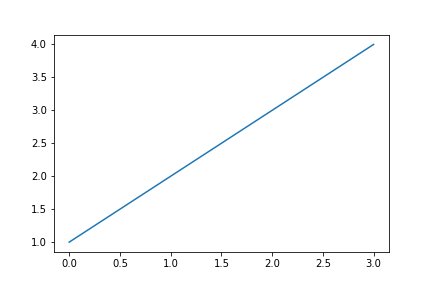

> 2023-02-13 00:15:04,194 [info] starting run my-function-log_plot uid=4c3b4eb0760749cfa21dbf2699846c18 DB=http://mlrun-api:8080
> 2023-02-13 00:15:04,382 [info] Job is running in the background, pod: my-function-log-plot-qqts4
> 2023-02-13 00:15:08,333 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:10,190 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 4c3b4eb0760749cfa21dbf2699846c18 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 4c3b4eb0760749cfa21dbf2699846c18 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:15:10,190 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/4c3b4eb0760749cfa21dbf2699846c18/overview'}
> 2023-02-13 00:15:10,191 [info]

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...99846c18,0,Feb 13 00:15:08,completed,my-function-log_plot,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-plot-qqts4,,,,my_plot


> 2023-02-13 00:15:10,671 [info] run executed, status=completed
> 2023-02-13 00:15:10,672 [info] {'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_plot/0/my_plot.html'}



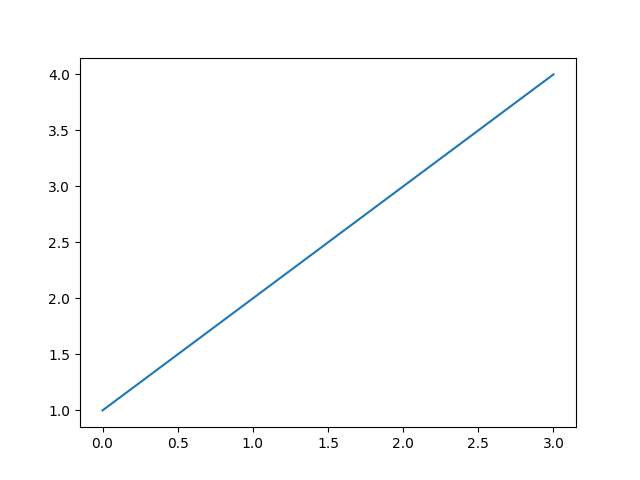

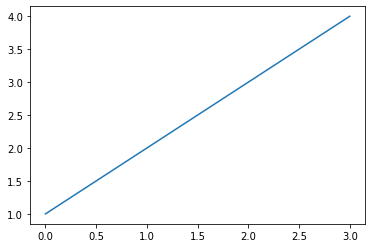

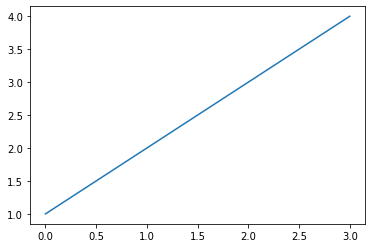

In [18]:
test_log_plot_without_mlrun()
test_log_plot_with_mlrun(local=True)
test_log_plot_with_mlrun(local=False)

### 2.6. Log Result

Run the `log_result` function to see the wrapper is logging the returned values as results.

In [19]:
def test_log_result_without_mlrun():
    my_int, my_float, my_dict, my_array = log_result()
    assert isinstance(my_int, int)
    assert isinstance(my_float, float)
    assert isinstance(my_dict, dict)
    assert isinstance(my_array, np.ndarray)


def test_log_result_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_result",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 4  # my_int, my_float, my_dict, my_array
    assert run_object.outputs["my_int"] == 1
    assert run_object.outputs["my_float"] == 1.5
    assert run_object.outputs["my_dict"] == {"a": 1, "b": 2}
    assert run_object.outputs["my_array"] == [1, 1, 1]

In [20]:
test_log_result_without_mlrun()
test_log_result_with_mlrun(local=True)
test_log_result_with_mlrun(local=False)

> 2023-02-13 00:15:10,962 [info] starting run my-function-log_result uid=919ae6833aed42de80363acdb40e0a86 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...b40e0a86,0,Feb 13 00:15:11,completed,my-function-log_result,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,"my_int=1my_float=1.5my_dict={'a': 1, 'b': 2}my_array=[1.0, 1.0, 1.0]",


> 2023-02-13 00:15:11,353 [info] run executed, status=completed
> 2023-02-13 00:15:11,354 [info] {'my_int': 1, 'my_float': 1.5, 'my_dict': {'a': 1, 'b': 2}, 'my_array': [1.0, 1.0, 1.0]}
> 2023-02-13 00:15:11,376 [info] starting run my-function-log_result uid=208da60402aa42649c63dfc6404a96e9 DB=http://mlrun-api:8080
> 2023-02-13 00:15:11,546 [info] Job is running in the background, pod: my-function-log-result-5svvp
> 2023-02-13 00:15:15,544 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:17,171 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 208da60402aa42649c63dfc6404a96e9 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 208da60402aa42649c63dfc6404a96e9 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:15:17,171 [info] Or click for UI: {'ui_url': 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...404a96e9,0,Feb 13 00:15:15,completed,my-function-log_result,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-result-5svvp,,,"my_int=1my_float=1.5my_dict={'a': 1, 'b': 2}my_array=[1.0, 1.0, 1.0]",


> 2023-02-13 00:15:17,793 [info] run executed, status=completed
> 2023-02-13 00:15:17,794 [info] {'my_int': 1, 'my_float': 1.5, 'my_dict': {'a': 1, 'b': 2}, 'my_array': [1.0, 1.0, 1.0]}


### 2.7 Log as Default Artifact Type

Run the `log_as_default_artifact_types` function to see the wrapper is logging the returned values as the correct default artifact types when the artifact types are not provided to the decorator.

In [21]:
def test_log_as_default_artifact_types_without_mlrun():
    (
        my_result,
        my_dataset,
        my_object,
        my_plot,
        my_imputer,
    ) = log_as_default_artifact_types()
    assert isinstance(my_result, int)
    assert isinstance(my_dataset, pd.DataFrame)
    assert isinstance(my_object, bytes)
    assert isinstance(my_plot, plt.Figure)
    assert isinstance(my_imputer, SimpleImputer)


def test_log_as_default_artifact_types_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_as_default_artifact_types",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert (
        len(run_object.outputs) == 5
    )  # my_result, my_dataset, my_object, my_plot, my_imputer
    assert run_object.outputs["my_result"] == 10
    assert run_object.artifact("my_dataset").as_df().shape == (10, 1)
    with open(run_object.artifact("my_object").local(), "rb") as pickle_file:
        my_object = cloudpickle.load(pickle_file)
    assert my_object == {"a": 5}
    assert isinstance(run_object.outputs["my_imputer"], str)
    run_object.artifact("my_plot").show()

> 2023-02-13 00:15:17,983 [info] starting run my-function-log_as_default_artifact_types uid=e96cef1d6f9a4b29b4bd072d55d169ae DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...55d169ae,0,Feb 13 00:15:18,completed,my-function-log_as_default_artifact_types,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,my_result=10my_imputer=SimpleImputer(),my_datasetmy_objectmy_plot


> 2023-02-13 00:15:18,462 [info] run executed, status=completed
> 2023-02-13 00:15:18,462 [info] {'my_result': 10, 'my_imputer': 'SimpleImputer()', 'my_dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_as_default_artifact_types_my_dataset:e96cef1d6f9a4b29b4bd072d55d169ae', 'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_as_default_artifact_types/0/my_object.pkl', 'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_as_default_artifact_types/0/my_plot.html'}
> 2023-02-13 00:15:18,487 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_as_default_artifact_types/0/my_object.pkl to local temp file



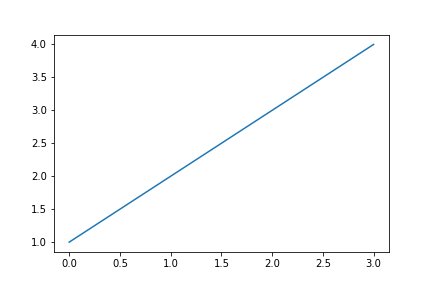

> 2023-02-13 00:15:18,529 [info] starting run my-function-log_as_default_artifact_types uid=0f9aae4389064bd5b98e07ae97a7b113 DB=http://mlrun-api:8080
> 2023-02-13 00:15:18,687 [info] Job is running in the background, pod: my-function-log-as-default-artifact-types-7hf76
> 2023-02-13 00:15:22,655 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:24,645 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 0f9aae4389064bd5b98e07ae97a7b113 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 0f9aae4389064bd5b98e07ae97a7b113 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:15:24,645 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/0f9aae4389064bd5b98e07ae97a7b113/o

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...97a7b113,0,Feb 13 00:15:22,completed,my-function-log_as_default_artifact_types,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-as-default-artifact-types-7hf76,,,my_result=10my_imputer=SimpleImputer(),my_datasetmy_objectmy_plot


> 2023-02-13 00:15:24,915 [info] run executed, status=completed
> 2023-02-13 00:15:24,915 [info] {'my_result': 10, 'my_imputer': 'SimpleImputer()', 'my_dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_as_default_artifact_types_my_dataset:0f9aae4389064bd5b98e07ae97a7b113', 'my_object': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_as_default_artifact_types/0/my_object.pkl', 'my_plot': 'v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_as_default_artifact_types/0/my_plot.html'}
> 2023-02-13 00:15:24,946 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_as_default_artifact_types/0/my_object.pkl to local temp file



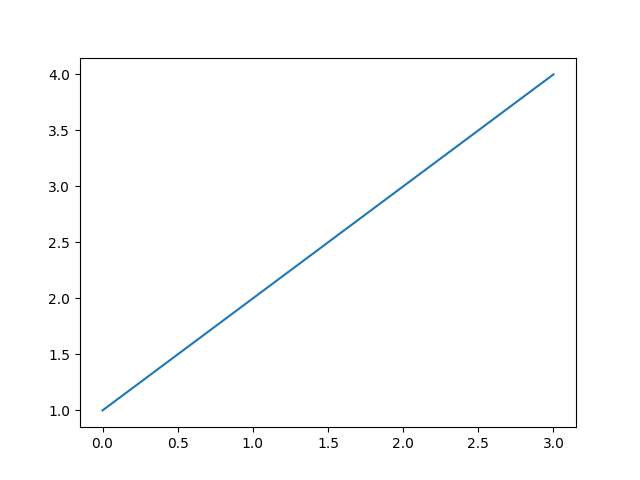

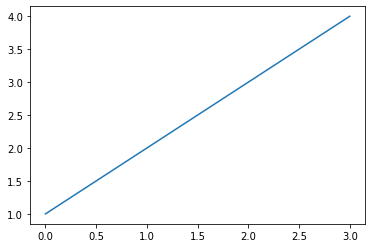

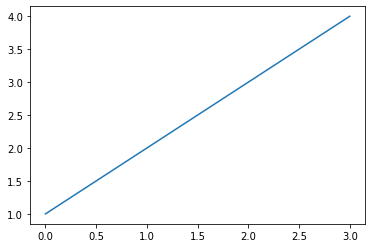

In [22]:
test_log_as_default_artifact_types_without_mlrun()
test_log_as_default_artifact_types_with_mlrun(local=True)
test_log_as_default_artifact_types_with_mlrun(local=False)

### 2.8. Log with `None` Values

Run the `log_with_none_values` function to see the wrapper is logging and ignoring the returned values as needed. Only result type should be logged as None, the dataset is needed to be ignored (not logged).

In [23]:
def test_log_with_none_values_without_mlrun():
    dataset, result, no_type, no_to_log = log_with_none_values()
    assert isinstance(dataset, np.ndarray)
    assert result == 5
    assert isinstance(no_type, np.ndarray)
    assert no_to_log == 10


def test_log_with_none_values_with_mlrun(
    is_none_dataset: bool, is_none_result: bool, is_none_no_type: bool, local: bool
):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_with_none_values",
        params={
            "is_none_dataset": is_none_dataset,
            "is_none_result": is_none_result,
            "is_none_no_type": is_none_no_type,
        },
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert (
        len(run_object.outputs) == (0 if is_none_dataset else 1) + 1 + 1
    )  # dataset only if True, result, no_type
    if not is_none_dataset:
        assert run_object.artifact("dataset").as_df().shape == (5, 5)
    assert run_object.outputs["result"] == "None" if is_none_result else 5
    if is_none_no_type:
        assert run_object.outputs["no_type"] == "None"
    else:
        assert run_object.artifact("no_type").as_df().shape == (10, 10)

In [24]:
test_log_with_none_values_without_mlrun()
for local in [True, False]:
    for is_none_dataset in [True, False]:
        for is_none_result in [True, False]:
            for is_none_no_type in [True, False]:
                test_log_with_none_values_with_mlrun(
                    is_none_dataset=is_none_dataset,
                    is_none_result=is_none_result,
                    is_none_no_type=is_none_no_type,
                    local=local
                )

> 2023-02-13 00:15:25,293 [info] starting run my-function-log_with_none_values uid=18b09add84fb437295ca31a6db3a0bf0 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...db3a0bf0,0,Feb 13 00:15:25,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,


> 2023-02-13 00:15:25,560 [info] run executed, status=completed
> 2023-02-13 00:15:25,560 [info] {'result': 'None', 'no_type': 'None'}
> 2023-02-13 00:15:25,582 [info] starting run my-function-log_with_none_values uid=25d722d5f1d94c7893f5a34122140527 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...22140527,0,Feb 13 00:15:25,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=False,result=None,no_type


> 2023-02-13 00:15:25,939 [info] run executed, status=completed
> 2023-02-13 00:15:25,939 [info] {'result': 'None', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:25d722d5f1d94c7893f5a34122140527'}
> 2023-02-13 00:15:25,997 [info] starting run my-function-log_with_none_values uid=63ccc28f680c4e6ea9d8680812cc7e2b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...12cc7e2b,0,Feb 13 00:15:26,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=True,result=5no_type=None,


> 2023-02-13 00:15:26,291 [info] run executed, status=completed
> 2023-02-13 00:15:26,292 [info] {'result': 5, 'no_type': 'None'}
> 2023-02-13 00:15:26,314 [info] starting run my-function-log_with_none_values uid=c914179972f04ff7bb7f35805409697a DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...5409697a,0,Feb 13 00:15:26,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=False,result=5,no_type


> 2023-02-13 00:15:26,985 [info] run executed, status=completed
> 2023-02-13 00:15:26,985 [info] {'result': 5, 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:c914179972f04ff7bb7f35805409697a'}
> 2023-02-13 00:15:27,051 [info] starting run my-function-log_with_none_values uid=e284a81a54214bc3aeb6684c24950bcc DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...24950bcc,0,Feb 13 00:15:27,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,dataset


> 2023-02-13 00:15:27,533 [info] run executed, status=completed
> 2023-02-13 00:15:27,534 [info] {'result': 'None', 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:e284a81a54214bc3aeb6684c24950bcc'}
> 2023-02-13 00:15:27,853 [info] starting run my-function-log_with_none_values uid=b6bcf77d09b34174bee7e9f1ca208a2b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ca208a2b,0,Feb 13 00:15:27,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=False,result=None,datasetno_type


> 2023-02-13 00:15:28,353 [info] run executed, status=completed
> 2023-02-13 00:15:28,354 [info] {'result': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:b6bcf77d09b34174bee7e9f1ca208a2b', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:b6bcf77d09b34174bee7e9f1ca208a2b'}
> 2023-02-13 00:15:28,440 [info] starting run my-function-log_with_none_values uid=7736c7ad81db496ba372d75ae0a7d3bc DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e0a7d3bc,0,Feb 13 00:15:28,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=True,result=5no_type=None,dataset


> 2023-02-13 00:15:28,882 [info] run executed, status=completed
> 2023-02-13 00:15:28,882 [info] {'result': 5, 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:7736c7ad81db496ba372d75ae0a7d3bc'}
> 2023-02-13 00:15:28,937 [info] starting run my-function-log_with_none_values uid=9e7701f52eac4935abe36e16660d7d26 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...660d7d26,0,Feb 13 00:15:29,completed,my-function-log_with_none_values,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=False,result=5,datasetno_type


> 2023-02-13 00:15:29,432 [info] run executed, status=completed
> 2023-02-13 00:15:29,432 [info] {'result': 5, 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:9e7701f52eac4935abe36e16660d7d26', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:9e7701f52eac4935abe36e16660d7d26'}
> 2023-02-13 00:15:29,503 [info] starting run my-function-log_with_none_values uid=0e0a23ca584743e096ec216f63b5c1b2 DB=http://mlrun-api:8080
> 2023-02-13 00:15:29,692 [info] Job is running in the background, pod: my-function-log-with-none-values-mwg2n
> 2023-02-13 00:15:33,528 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:35,131 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 0e0a

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...63b5c1b2,0,Feb 13 00:15:33,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-mwg2n,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,


> 2023-02-13 00:15:35,917 [info] run executed, status=completed
> 2023-02-13 00:15:35,918 [info] {'result': 'None', 'no_type': 'None'}
> 2023-02-13 00:15:35,942 [info] starting run my-function-log_with_none_values uid=60782f5d4dae4efc9ccbb5c1977670a9 DB=http://mlrun-api:8080
> 2023-02-13 00:15:36,103 [info] Job is running in the background, pod: my-function-log-with-none-values-bhm8s
> 2023-02-13 00:15:40,133 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:41,864 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 60782f5d4dae4efc9ccbb5c1977670a9 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 60782f5d4dae4efc9ccbb5c1977670a9 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:15:41,864 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tena

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...977670a9,0,Feb 13 00:15:40,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-bhm8s,,is_none_dataset=Trueis_none_result=Trueis_none_no_type=False,result=None,no_type


> 2023-02-13 00:15:42,372 [info] run executed, status=completed
> 2023-02-13 00:15:42,373 [info] {'result': 'None', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:60782f5d4dae4efc9ccbb5c1977670a9'}
> 2023-02-13 00:15:42,428 [info] starting run my-function-log_with_none_values uid=dc427c52b80149d28e9ea9cef9e2dd67 DB=http://mlrun-api:8080
> 2023-02-13 00:15:42,601 [info] Job is running in the background, pod: my-function-log-with-none-values-wtqhg
> 2023-02-13 00:15:46,454 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:48,054 [info] To track results use the CLI: {'info_cmd': 'mlrun get run dc427c52b80149d28e9ea9cef9e2dd67 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs dc427c52b80149d28e9ea9cef9e2dd67 -p mlrun-h

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f9e2dd67,0,Feb 13 00:15:46,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-wtqhg,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=True,result=5no_type=None,


> 2023-02-13 00:15:48,807 [info] run executed, status=completed
> 2023-02-13 00:15:48,807 [info] {'result': 5, 'no_type': 'None'}
> 2023-02-13 00:15:48,828 [info] starting run my-function-log_with_none_values uid=c046241f7e6f4acb8f2e17d61f752f9c DB=http://mlrun-api:8080
> 2023-02-13 00:15:48,987 [info] Job is running in the background, pod: my-function-log-with-none-values-z7wv2
> 2023-02-13 00:15:52,937 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:15:54,668 [info] To track results use the CLI: {'info_cmd': 'mlrun get run c046241f7e6f4acb8f2e17d61f752f9c -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs c046241f7e6f4acb8f2e17d61f752f9c -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:15:54,668 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.ap

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...1f752f9c,0,Feb 13 00:15:52,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-z7wv2,,is_none_dataset=Trueis_none_result=Falseis_none_no_type=False,result=5,no_type


> 2023-02-13 00:15:55,231 [info] run executed, status=completed
> 2023-02-13 00:15:55,231 [info] {'result': 5, 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:c046241f7e6f4acb8f2e17d61f752f9c'}
> 2023-02-13 00:15:55,295 [info] starting run my-function-log_with_none_values uid=c21cb17bd2f942f88d95ea8ded18587b DB=http://mlrun-api:8080
> 2023-02-13 00:15:55,473 [info] Job is running in the background, pod: my-function-log-with-none-values-6np97
> 2023-02-13 00:15:59,332 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:01,122 [info] To track results use the CLI: {'info_cmd': 'mlrun get run c21cb17bd2f942f88d95ea8ded18587b -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs c21cb17bd2f942f88d95ea8ded18587b -p mlrun-handle

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ed18587b,0,Feb 13 00:15:59,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-6np97,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=True,result=Noneno_type=None,dataset


> 2023-02-13 00:16:01,937 [info] run executed, status=completed
> 2023-02-13 00:16:01,938 [info] {'result': 'None', 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:c21cb17bd2f942f88d95ea8ded18587b'}
> 2023-02-13 00:16:01,990 [info] starting run my-function-log_with_none_values uid=f636beffdf2545a38b929ce3f21d8287 DB=http://mlrun-api:8080
> 2023-02-13 00:16:02,193 [info] Job is running in the background, pod: my-function-log-with-none-values-jzxmx
> 2023-02-13 00:16:06,131 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:08,013 [info] To track results use the CLI: {'info_cmd': 'mlrun get run f636beffdf2545a38b929ce3f21d8287 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs f636beffdf2545a38b929ce3

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f21d8287,0,Feb 13 00:16:06,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-jzxmx,,is_none_dataset=Falseis_none_result=Trueis_none_no_type=False,result=None,datasetno_type


> 2023-02-13 00:16:08,482 [info] run executed, status=completed
> 2023-02-13 00:16:08,482 [info] {'result': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:f636beffdf2545a38b929ce3f21d8287', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:f636beffdf2545a38b929ce3f21d8287'}
> 2023-02-13 00:16:08,576 [info] starting run my-function-log_with_none_values uid=4c86c9b466b94ee38df4e75483931525 DB=http://mlrun-api:8080
> 2023-02-13 00:16:08,755 [info] Job is running in the background, pod: my-function-log-with-none-values-tg4dw
> 2023-02-13 00:16:12,717 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:14,446 [info] To track results use the CLI: {'info_cmd': 'mlrun get run

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...83931525,0,Feb 13 00:16:12,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-tg4dw,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=True,result=5no_type=None,dataset


> 2023-02-13 00:16:15,035 [info] run executed, status=completed
> 2023-02-13 00:16:15,036 [info] {'result': 5, 'no_type': 'None', 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:4c86c9b466b94ee38df4e75483931525'}
> 2023-02-13 00:16:15,099 [info] starting run my-function-log_with_none_values uid=f422dc2bb18e4e54b3c3b70972611fe7 DB=http://mlrun-api:8080
> 2023-02-13 00:16:15,278 [info] Job is running in the background, pod: my-function-log-with-none-values-567sn
> 2023-02-13 00:16:19,148 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:20,993 [info] To track results use the CLI: {'info_cmd': 'mlrun get run f422dc2bb18e4e54b3c3b70972611fe7 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs f422dc2bb18e4e54b3c3b70972611

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...72611fe7,0,Feb 13 00:16:19,completed,my-function-log_with_none_values,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-with-none-values-567sn,,is_none_dataset=Falseis_none_result=Falseis_none_no_type=False,result=5,datasetno_type


> 2023-02-13 00:16:21,523 [info] run executed, status=completed
> 2023-02-13 00:16:21,523 [info] {'result': 5, 'dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_dataset:f422dc2bb18e4e54b3c3b70972611fe7', 'no_type': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_with_none_values_no_type:f422dc2bb18e4e54b3c3b70972611fe7'}


### 2.9. Log from Function and Wrapper

Run the `log_from_function_and_wrapper` function to see the wrapper is logging the returned values among the other values logged via the context manually inside the function.

In [25]:
def test_log_from_function_and_wrapper_without_mlrun():
    my_dataset, my_result = log_from_function_and_wrapper()
    assert isinstance(my_dataset, list)
    assert isinstance(my_result, str)


def test_log_from_function_and_wrapper_with_mlrun(local: bool):
    # Run the function:
    run_object = mlrun_function.run(
        handler="log_from_function_and_wrapper",
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert (
        len(run_object.outputs) == 4
    )  # context_dataset, context_result, wrapper_dataset, wrapper_result
    assert run_object.artifact("context_dataset").as_df().shape == (10, 1)
    assert run_object.outputs["context_result"] == 1
    assert run_object.artifact("wrapper_dataset").as_df().shape == (4, 1)
    assert run_object.outputs["wrapper_result"] == "hello"

In [26]:
test_log_from_function_and_wrapper_without_mlrun()
test_log_from_function_and_wrapper_with_mlrun(local=True)
test_log_from_function_and_wrapper_with_mlrun(local=False)

> 2023-02-13 00:16:21,703 [info] starting run my-function-log_from_function_and_wrapper uid=5a048b2b0574478a8bf955de3e250768 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...3e250768,0,Feb 13 00:16:21,completed,my-function-log_from_function_and_wrapper,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,context_result=1wrapper_result=hello,context_datasetwrapper_dataset


> 2023-02-13 00:16:22,145 [info] run executed, status=completed
> 2023-02-13 00:16:22,146 [info] {'context_result': 1, 'wrapper_result': 'hello', 'context_dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_from_function_and_wrapper_context_dataset:5a048b2b0574478a8bf955de3e250768', 'wrapper_dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_from_function_and_wrapper_wrapper_dataset:5a048b2b0574478a8bf955de3e250768'}
> 2023-02-13 00:16:22,216 [info] starting run my-function-log_from_function_and_wrapper uid=92c048bdba494f2da70b385fc6e5cf6f DB=http://mlrun-api:8080
> 2023-02-13 00:16:22,394 [info] Job is running in the background, pod: my-function-log-from-function-and-wrapper-4wxlf
> 2023-02-13 00:16:26,347 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...c6e5cf6f,0,Feb 13 00:16:26,completed,my-function-log_from_function_and_wrapper,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-from-function-and-wrapper-4wxlf,,,context_result=1wrapper_result=hello,context_datasetwrapper_dataset


> 2023-02-13 00:16:28,633 [info] run executed, status=completed
> 2023-02-13 00:16:28,633 [info] {'context_result': 1, 'wrapper_result': 'hello', 'context_dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_from_function_and_wrapper_context_dataset:92c048bdba494f2da70b385fc6e5cf6f', 'wrapper_dataset': 'store://artifacts/mlrun-handler-tests-guyl/my-function-log_from_function_and_wrapper_wrapper_dataset:92c048bdba494f2da70b385fc6e5cf6f'}


## 3. Parsing Inputs

### 3.1. Parse Inputs from Type Hints

Run the `parse_inputs_from_type_hints` function to see the wrapper is parsing the given inputs (`DataItem`s) to the written type hints.

In [27]:
def test_parse_inputs_from_type_hints_without_mlrun():
    _, _, _, my_data = log_dataset()
    my_encoder = log_object()
    result = parse_inputs_from_type_hints(
        my_data, my_encoder=my_encoder, data_2=None, data_3=None, add=1
    )
    assert isinstance(result, list)
    assert result == [[2], [3], [4]]


def test_parse_inputs_from_type_hints_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="parse_inputs_from_type_hints",
        inputs={
            "my_data": log_dataset_run.outputs["my_list"],
            "my_encoder": log_object_run.outputs["my_object"],
            "data_2": log_dataset_run.outputs["my_array"],
            "data_3": log_dataset_run.outputs["my_dict"],
        },
        params={"add": 1},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # return

In [28]:
test_parse_inputs_from_type_hints_without_mlrun()
test_parse_inputs_from_type_hints_with_mlrun(local=True)
test_parse_inputs_from_type_hints_with_mlrun(local=False)

> 2023-02-13 00:16:29,162 [info] starting run my-function-log_dataset uid=db520a15324e4d9aa1a10eb426b5a966 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...26b5a966,0,Feb 13 00:16:29,completed,my-function-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:16:30,463 [info] run executed, status=completed
> 2023-02-13 00:16:30,487 [info] starting run my-function-log_object uid=0a1d75d850024ad6825350af9816666d DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...9816666d,0,Feb 13 00:16:30,completed,my-function-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_object


> 2023-02-13 00:16:30,787 [info] run executed, status=completed
> 2023-02-13 00:16:30,809 [info] starting run my-function-parse_inputs_from_type_hints uid=5926cac5cbc04d76a4d4a797f3fc6725 DB=http://mlrun-api:8080
> 2023-02-13 00:16:31,100 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f3fc6725,0,Feb 13 00:16:30,completed,my-function-parse_inputs_from_type_hints,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,my_datamy_encoderdata_2data_3,add=1,"return=[[2.0], [3.0], [4.0]]",


> 2023-02-13 00:16:31,377 [info] run executed, status=completed
> 2023-02-13 00:16:31,377 [info] {'return': [[2.0], [3.0], [4.0]]}
> 2023-02-13 00:16:31,403 [info] starting run my-function-log_dataset uid=5caf45ffdedf43a0bd142f96e1f7d493 DB=http://mlrun-api:8080
> 2023-02-13 00:16:31,568 [info] Job is running in the background, pod: my-function-log-dataset-99hx9
> 2023-02-13 00:16:35,455 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:37,796 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 5caf45ffdedf43a0bd142f96e1f7d493 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 5caf45ffdedf43a0bd142f96e1f7d493 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:16:37,796 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.igua

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e1f7d493,0,Feb 13 00:16:35,completed,my-function-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-dataset-99hx9,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:16:40,884 [info] run executed, status=completed
> 2023-02-13 00:16:40,906 [info] starting run my-function-log_object uid=470e857293f947249ad661339d9a4c01 DB=http://mlrun-api:8080
> 2023-02-13 00:16:41,075 [info] Job is running in the background, pod: my-function-log-object-2dtlm
> 2023-02-13 00:16:44,937 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:46,591 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 470e857293f947249ad661339d9a4c01 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 470e857293f947249ad661339d9a4c01 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:16:46,591 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/470e8572

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...9d9a4c01,0,Feb 13 00:16:44,completed,my-function-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-object-2dtlm,,,,my_object


> 2023-02-13 00:16:47,342 [info] run executed, status=completed
> 2023-02-13 00:16:47,365 [info] starting run my-function-parse_inputs_from_type_hints uid=aa9791d06220407a94a887ea457b819b DB=http://mlrun-api:8080
> 2023-02-13 00:16:47,532 [info] Job is running in the background, pod: my-function-parse-inputs-from-type-hints-rfzdn
> 2023-02-13 00:16:51,335 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:16:52,996 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file
> 2023-02-13 00:16:53,064 [info] To track results use the CLI: {'info_cmd': 'mlrun get run aa9791d06220407a94a887ea457b819b -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs aa9791d06220407a94a887ea457b819b -p mlrun-handler-tests

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...457b819b,0,Feb 13 00:16:51,completed,my-function-parse_inputs_from_type_hints,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-parse-inputs-from-type-hints-rfzdn,my_datamy_encoderdata_2data_3,add=1,"return=[[2.0], [3.0], [4.0]]",


> 2023-02-13 00:16:53,830 [info] run executed, status=completed
> 2023-02-13 00:16:53,830 [info] {'return': [[2.0], [3.0], [4.0]]}


### 3.2. Parse Inputs from Wrapper (`type`s)

Run the `parse_inputs_from_wrapper_using_types` function to see the wrapper is parsing the given inputs (`DataItem`s) to the written types configuration provided to the wrapper.

In [29]:
def test_parse_inputs_from_wrapper_using_types_without_mlrun():
    _, _, _, my_data = log_dataset()
    my_encoder = log_object()
    result = parse_inputs_from_wrapper_using_types(
        pd.DataFrame(my_data), my_encoder=my_encoder, add=1
    )
    assert isinstance(result, list)
    assert result == [[2], [3], [4]]


def test_parse_inputs_from_wrapper_using_types_with_mlrun(local: bool):
    # Create the function and run 2 of the previous functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="parse_inputs_from_wrapper_using_types",
        inputs={
            "my_data": log_dataset_run.outputs["my_list"],
            "my_encoder": log_object_run.outputs["my_object"],
        },
        params={"add": 1},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # return

In [30]:
test_parse_inputs_from_wrapper_using_types_without_mlrun()
test_parse_inputs_from_wrapper_using_types_with_mlrun(local=True)
test_parse_inputs_from_wrapper_using_types_with_mlrun(local=False)

> 2023-02-13 00:16:54,030 [info] starting run my-function-log_dataset uid=a2ab6b3986d848f6afd8f4c734af52f8 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...34af52f8,0,Feb 13 00:16:54,completed,my-function-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:16:55,045 [info] run executed, status=completed
> 2023-02-13 00:16:55,069 [info] starting run my-function-log_object uid=868ceacbcd074a8297b5a289ebcb5757 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ebcb5757,0,Feb 13 00:16:55,completed,my-function-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_object


> 2023-02-13 00:16:55,413 [info] run executed, status=completed
> 2023-02-13 00:16:55,435 [info] starting run my-function-parse_inputs_from_wrapper_using_types uid=afd598109baf43f0b73c440fae94946d DB=http://mlrun-api:8080
> 2023-02-13 00:16:55,787 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...ae94946d,0,Feb 13 00:16:55,completed,my-function-parse_inputs_from_wrapper_using_types,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,my_datamy_encoder,add=1,"return=[[2.0], [3.0], [4.0]]",


> 2023-02-13 00:16:55,899 [info] run executed, status=completed
> 2023-02-13 00:16:55,899 [info] {'return': [[2.0], [3.0], [4.0]]}
> 2023-02-13 00:16:55,922 [info] starting run my-function-log_dataset uid=f7ecdf1931924fbb8aca7397441eede4 DB=http://mlrun-api:8080
> 2023-02-13 00:16:56,094 [info] Job is running in the background, pod: my-function-log-dataset-24mz8
> 2023-02-13 00:17:00,028 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:02,400 [info] To track results use the CLI: {'info_cmd': 'mlrun get run f7ecdf1931924fbb8aca7397441eede4 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs f7ecdf1931924fbb8aca7397441eede4 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:17:02,400 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.igua

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...441eede4,0,Feb 13 00:17:00,completed,my-function-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-dataset-24mz8,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:17:05,489 [info] run executed, status=completed
> 2023-02-13 00:17:05,510 [info] starting run my-function-log_object uid=ca8b999f755442d7a92391be0faed3c2 DB=http://mlrun-api:8080
> 2023-02-13 00:17:05,687 [info] Job is running in the background, pod: my-function-log-object-wsxh4
> 2023-02-13 00:17:09,574 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:11,263 [info] To track results use the CLI: {'info_cmd': 'mlrun get run ca8b999f755442d7a92391be0faed3c2 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs ca8b999f755442d7a92391be0faed3c2 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:17:11,263 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/ca8b999f

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...0faed3c2,0,Feb 13 00:17:09,completed,my-function-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-object-wsxh4,,,,my_object


> 2023-02-13 00:17:11,997 [info] run executed, status=completed
> 2023-02-13 00:17:12,018 [info] starting run my-function-parse_inputs_from_wrapper_using_types uid=70440a546d9c4adabb9917972c48a78a DB=http://mlrun-api:8080
> 2023-02-13 00:17:12,179 [info] Job is running in the background, pod: my-function-parse-inputs-from-wrapper-using-types-4dlvx
> 2023-02-13 00:17:16,147 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:17,749 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file
> 2023-02-13 00:17:17,815 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 70440a546d9c4adabb9917972c48a78a -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 70440a546d9c4adabb9917972c48a78a -p m

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...2c48a78a,0,Feb 13 00:17:16,completed,my-function-parse_inputs_from_wrapper_using_types,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-parse-inputs-from-wrapper-using-types-4dlvx,my_datamy_encoder,add=1,"return=[[2.0], [3.0], [4.0]]",


> 2023-02-13 00:17:18,396 [info] run executed, status=completed
> 2023-02-13 00:17:18,397 [info] {'return': [[2.0], [3.0], [4.0]]}


### 3.3. Parse Inputs from Wrapper (`str`s)

Run the `parse_inputs_from_wrapper_using_strings` function to see the wrapper is parsing the given inputs (`DataItem`s) to the written strings configuration provided to the wrapper.

In [31]:
def test_parse_inputs_from_wrapper_using_strings_without_mlrun():
    my_array, my_df, _, my_list = log_dataset()
    my_encoder = log_object()
    result = parse_inputs_from_wrapper_using_strings(
        my_list, my_array, my_df=my_df, my_encoder=my_encoder, add=1
    )
    assert isinstance(result, int)
    assert result == 402


def test_parse_inputs_from_wrapper_using_strings_with_mlrun(local: bool):
    # Create the function and run 2 of the previous functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="parse_inputs_from_wrapper_using_strings",
        inputs={
            "my_list": log_dataset_run.outputs["my_list"],
            "my_array": log_dataset_run.outputs["my_array"],
            "my_df": log_dataset_run.outputs["my_df"],
            "my_encoder": log_object_run.outputs["my_object"],
        },
        params={"add": 1},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1  # result
    assert run_object.outputs["result"] == 402

In [32]:
test_parse_inputs_from_wrapper_using_strings_without_mlrun()
test_parse_inputs_from_wrapper_using_strings_with_mlrun(local=True)
test_parse_inputs_from_wrapper_using_strings_with_mlrun(local=False)

> 2023-02-13 00:17:18,548 [info] starting run my-function-log_dataset uid=ab98810c6db74e9ca735cd897aea7f27 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...7aea7f27,0,Feb 13 00:17:18,completed,my-function-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:17:19,545 [info] run executed, status=completed
> 2023-02-13 00:17:19,569 [info] starting run my-function-log_object uid=80bb431773c44f8a85267f9248c7a4d3 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...48c7a4d3,0,Feb 13 00:17:19,completed,my-function-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_object


> 2023-02-13 00:17:19,866 [info] run executed, status=completed
> 2023-02-13 00:17:19,890 [info] starting run my-function-parse_inputs_from_wrapper_using_strings uid=97f944e6b0ff490d92a55523d9025c78 DB=http://mlrun-api:8080
> 2023-02-13 00:17:20,343 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...d9025c78,0,Feb 13 00:17:20,completed,my-function-parse_inputs_from_wrapper_using_strings,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,my_listmy_arraymy_dfmy_encoder,add=1,result=402,


> 2023-02-13 00:17:20,527 [info] run executed, status=completed
> 2023-02-13 00:17:20,527 [info] {'result': 402}
> 2023-02-13 00:17:20,559 [info] starting run my-function-log_dataset uid=c57bbe8bc19f4cb4a594a222e8c75ed0 DB=http://mlrun-api:8080
> 2023-02-13 00:17:20,738 [info] Job is running in the background, pod: my-function-log-dataset-zxxvg
> 2023-02-13 00:17:24,541 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:26,920 [info] To track results use the CLI: {'info_cmd': 'mlrun get run c57bbe8bc19f4cb4a594a222e8c75ed0 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs c57bbe8bc19f4cb4a594a222e8c75ed0 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:17:26,920 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlproj

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e8c75ed0,0,Feb 13 00:17:24,completed,my-function-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-dataset-zxxvg,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:17:30,028 [info] run executed, status=completed
> 2023-02-13 00:17:30,051 [info] starting run my-function-log_object uid=563947d6dcd84771843f18d0f4eb15a9 DB=http://mlrun-api:8080
> 2023-02-13 00:17:30,245 [info] Job is running in the background, pod: my-function-log-object-qfg9d
> 2023-02-13 00:17:34,221 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:35,893 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 563947d6dcd84771843f18d0f4eb15a9 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 563947d6dcd84771843f18d0f4eb15a9 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:17:35,893 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/563947d6

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...f4eb15a9,0,Feb 13 00:17:34,completed,my-function-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-object-qfg9d,,,,my_object


> 2023-02-13 00:17:36,489 [info] run executed, status=completed
> 2023-02-13 00:17:36,535 [info] starting run my-function-parse_inputs_from_wrapper_using_strings uid=9fd4c805f60241048eab154ec9a3b71a DB=http://mlrun-api:8080
> 2023-02-13 00:17:36,722 [info] Job is running in the background, pod: my-function-parse-inputs-from-wrapper-using-strings-27kh2
> 2023-02-13 00:17:40,540 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:42,218 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file
> 2023-02-13 00:17:42,301 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 9fd4c805f60241048eab154ec9a3b71a -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 9fd4c805f60241048eab154ec9a3b71a 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...c9a3b71a,0,Feb 13 00:17:40,completed,my-function-parse_inputs_from_wrapper_using_strings,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-parse-inputs-from-wrapper-using-strings-27kh2,my_listmy_arraymy_dfmy_encoder,add=1,result=402,


> 2023-02-13 00:17:42,962 [info] run executed, status=completed
> 2023-02-13 00:17:42,963 [info] {'result': 402}


## 4. Raising Errors

### 4.1. Raise Error while Logging

Run the `log_from_function_and_wrapper` function to see the wrapper is logging the returned values among the other values logged via the context manually inside the function.

In [33]:
def test_raise_error_while_logging_with_mlrun(local: bool):
    # Run and expect an error:
    try:
        mlrun_function.run(
            handler="raise_error_while_logging",
            local=local,
        )
        assert False
    except Exception as e:
        mlrun.utils.logger.info(e)
        assert "MLRun tried to log 'error_numpy' as " in str(e)

In [34]:
test_raise_error_while_logging_with_mlrun(local=True)
test_raise_error_while_logging_with_mlrun(local=False)

> 2023-02-13 00:17:43,016 [info] starting run my-function-raise_error_while_logging uid=9269e9cb6f9a42a3810cb83748258292 DB=http://mlrun-api:8080
> 2023-02-13 00:17:43,252 [error] execution error, Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/runtimes/package/context_handler.py", line 703, in _log_output
    logging_kwargs=logging_kwargs,
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/runtimes/package/context_handler.py", line 144, in log_dataset
    obj = pd.DataFrame(obj)
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/pandas/core/frame.py", line 678, in __init__
    typ=manager,
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 304, in ndarray_to_mgr
    values = _prep_ndarray(values, copy=copy)
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 555, in _pr

MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`., caused by: Must pass 2-d input. shape=(7, 7, 7)


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...48258292,0,Feb 13 00:17:43,error,my-function-raise_error_while_logging,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,


> 2023-02-13 00:17:43,374 [info] run executed, status=error
> 2023-02-13 00:17:43,375 [info] MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`., caused by: Must pass 2-d input. shape=(7, 7, 7)
> 2023-02-13 00:17:43,398 [info] starting run my-function-raise_error_while_logging uid=78cce90299754674a920da642eb20fd1 DB=http://mlrun-api:8080
> 2023-02-13 00:17:43,581 [info] Job is running in the background, pod: my-function-raise-error-while-logging-4wtdv
> 2023-02-13 00:17:47,439 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:48,963 [error] execution error, Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...2eb20fd1,0,Feb 13 00:17:47,error,my-function-raise_error_while_logging,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-raise-error-while-logging-4wtdv,,,,


> 2023-02-13 00:17:49,791 [info] run executed, status=error
> 2023-02-13 00:17:49,792 [error] runtime error: MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`., caused by: Must pass 2-d input. shape=(7, 7, 7)
> 2023-02-13 00:17:49,792 [info] MLRun tried to log 'error_numpy' as 'dataset' but failed. If you didn't provide the artifact type and the default one does not fit, try to select the correct type from the enum `ArtifactType`., caused by: Must pass 2-d input. shape=(7, 7, 7)


### 4.2. Raise Error while Parsing

Run the `parse_inputs_from_wrapper_using_types` function and send it wrong types to see the wrapper is raising the relevant exception.

In [35]:
def test_raise_error_while_parsing_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="log_dataset",
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="log_object",
        local=local,
    )

    # Run the function that will parse the data items and expect an error:
    try:
        mlrun_function.run(
            handler="parse_inputs_from_wrapper_using_types",
            inputs={
                "my_data": log_object_run.outputs["my_object"],
                "my_encoder": log_dataset_run.outputs["my_list"],
            },
            params={"add": 1},
            local=local,
        )
        assert False
    except Exception as e:
        mlrun.utils.logger.info(e)
        assert "MLRun tried to parse a `DataItem` of type " in str(e)

In [36]:
test_raise_error_while_parsing_with_mlrun(local=True)
test_raise_error_while_parsing_with_mlrun(local=False)

> 2023-02-13 00:17:49,835 [info] starting run my-function-log_dataset uid=f105fa1438dc4eaab7a5c370eb81110b DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...eb81110b,0,Feb 13 00:17:49,completed,my-function-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:17:50,840 [info] run executed, status=completed
> 2023-02-13 00:17:50,864 [info] starting run my-function-log_object uid=b485d0eab24549d485e299b3e4367988 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e4367988,0,Feb 13 00:17:50,completed,my-function-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,,,my_object


> 2023-02-13 00:17:51,167 [info] run executed, status=completed
> 2023-02-13 00:17:51,190 [info] starting run my-function-parse_inputs_from_wrapper_using_types uid=73f70e2797cb4a6db65642946450cea4 DB=http://mlrun-api:8080
> 2023-02-13 00:17:51,545 [error] execution error, Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/runtimes/package/context_handler.py", line 661, in _parse_input
    )(data_item=data_item)
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/runtimes/package/context_handler.py", line 99, in parse_list
    return data_item.as_df().to_numpy().tolist()
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/datastore/base.py", line 395, in as_df
    **kwargs,
  File "/User/.pythonlibs/jupyter-guyl/lib/python3.7/site-packages/mlrun/datastore/base.py", line 191, in as_df
    raise Exception(f"file type unhandled {url}")
Exception: file type unhandled v3io:///projects/mlrun-han

MLRun tried to parse a `DataItem` of type '<class 'list'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles., caused by: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...6450cea4,0,Feb 13 00:17:51,"' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles., caused by: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl"">error",my-function-parse_inputs_from_wrapper_using_types,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,my_datamy_encoder,add=1,,


> 2023-02-13 00:17:51,672 [info] run executed, status=error
> 2023-02-13 00:17:51,672 [info] MLRun tried to parse a `DataItem` of type '<class 'list'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles., caused by: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl
> 2023-02-13 00:17:51,693 [info] starting run my-function-log_dataset uid=380eb0e1322a4fe5b5cfd699b3025335 DB=http://mlrun-api:8080
> 2023-02-13 00:17:51,859 [info] Job is running in the background, pod: my-function-log-dataset-2w25d
> 2023-02-13 00:17:55,848 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:17:58,244 [info] To track results use t

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...b3025335,0,Feb 13 00:17:55,completed,my-function-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-dataset-2w25d,,,,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:18:01,152 [info] run executed, status=completed
> 2023-02-13 00:18:01,179 [info] starting run my-function-log_object uid=a648d0de6a1d481b9b153cb02a58871e DB=http://mlrun-api:8080
> 2023-02-13 00:18:01,356 [info] Job is running in the background, pod: my-function-log-object-vfs24
> 2023-02-13 00:18:05,262 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:18:06,886 [info] To track results use the CLI: {'info_cmd': 'mlrun get run a648d0de6a1d481b9b153cb02a58871e -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs a648d0de6a1d481b9b153cb02a58871e -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:18:06,887 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/a648d0de

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...2a58871e,0,Feb 13 00:18:05,completed,my-function-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-object-vfs24,,,,my_object


> 2023-02-13 00:18:07,641 [info] run executed, status=completed
> 2023-02-13 00:18:07,662 [info] starting run my-function-parse_inputs_from_wrapper_using_types uid=74056cb65b7b4d358d2469664d6ee808 DB=http://mlrun-api:8080
> 2023-02-13 00:18:07,822 [info] Job is running in the background, pod: my-function-parse-inputs-from-wrapper-using-types-bxtb5
> 2023-02-13 00:18:11,728 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:18:13,305 [error] execution error, Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/mlrun/runtimes/package/context_handler.py", line 659, in _parse_input
    return self._INPUTS_PARSING_MAP.get(
  File "/usr/local/lib/python3.9/site-packages/mlrun/runtimes/package/context_handler.py", line 99, in parse_list
    return d

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...4d6ee808,0,Feb 13 00:18:11,"' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles., caused by: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl"">error",my-function-parse_inputs_from_wrapper_using_types,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-parse-inputs-from-wrapper-using-types-bxtb5,my_datamy_encoder,add=1,,


> 2023-02-13 00:18:14,052 [info] run executed, status=error
> 2023-02-13 00:18:14,052 [error] runtime error: MLRun tried to parse a `DataItem` of type '<class 'list'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles., caused by: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl
> 2023-02-13 00:18:14,053 [info] MLRun tried to parse a `DataItem` of type '<class 'list'>' but failed. Be sure the item was logged correctly - as the type you are trying to parse it back to. In general, python objects should be logged as pickles., caused by: file type unhandled v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl


## 5. Supporting class methods

Run multiple decorated methods of the class `MyClass` to see the decorator is working as expected (even on class methods). 

In [37]:
def test_class_methods_without_mlrun():
    my_class = MyClass(class_parameter=1)

    my_array, my_df, my_dict, my_list = my_class.log_dataset()
    assert isinstance(my_array, np.ndarray)
    assert isinstance(my_df, pd.DataFrame)
    assert isinstance(my_dict, dict)
    assert isinstance(my_list, list)

    my_object = my_class.log_object()
    assert isinstance(my_object, Pipeline)
    assert my_object.transform([["A"], ["B"], [""]]).tolist() == [[0], [1], [2]]

    result = my_class.parse_inputs_from_type_hints(
        my_list, my_encoder=my_object, data_2=None, data_3=None, mul=2
    )
    assert result == 9


def test_class_methods_with_mlrun(local: bool):
    # Run the following functions to create a dataset and encoder objects:
    log_dataset_run = mlrun_function.run(
        handler="MyClass::log_dataset",
        params={"_init_args": {"class_parameter": 1}},
        local=local,
    )
    log_object_run = mlrun_function.run(
        handler="MyClass::log_object",
        params={"_init_args": {"class_parameter": 1}},
        local=local,
    )

    # Run the function that will parse the data items:
    run_object = mlrun_function.run(
        handler="MyClass::parse_inputs_from_type_hints",
        inputs={
            "my_data": log_dataset_run.outputs["my_list"],
            "my_encoder": log_object_run.outputs["my_object"],
            "data_2": log_dataset_run.outputs["my_array"],
            "data_3": log_dataset_run.outputs["my_dict"],
        },
        params={"_init_args": {"class_parameter": 1}, "mul": 2},
        local=local,
    )

    # Manual validation:
    mlrun.utils.logger.info(run_object.outputs)

    # Assertion:
    assert len(run_object.outputs) == 1
    assert run_object.outputs["result"] == 9

In [38]:
test_class_methods_without_mlrun()
test_class_methods_with_mlrun(local=True)
test_class_methods_with_mlrun(local=False)

> 2023-02-13 00:18:14,199 [info] starting run my-function-log_dataset uid=7f9da6a1058646d3acf72c9de1bae2aa DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...e1bae2aa,0,Feb 13 00:18:14,completed,my-function-log_dataset,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,_init_args={'class_parameter': 1},,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:18:15,211 [info] run executed, status=completed
> 2023-02-13 00:18:15,234 [info] starting run my-function-log_object uid=d76ca7c7f9474eefaca7836895df7b27 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...95df7b27,0,Feb 13 00:18:15,completed,my-function-log_object,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,,_init_args={'class_parameter': 1},,my_object


> 2023-02-13 00:18:15,541 [info] run executed, status=completed
> 2023-02-13 00:18:15,563 [info] starting run my-function-parse_inputs_from_type_hints uid=0034d27ef9784f99be98bc2bdbce2dec DB=http://mlrun-api:8080
> 2023-02-13 00:18:16,069 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...dbce2dec,0,Feb 13 00:18:15,completed,my-function-parse_inputs_from_type_hints,v3io_user=guylkind=owner=guylhost=jupyter-guyl-65dfdbf79-tm98j,my_datamy_encoderdata_2data_3,_init_args={'class_parameter': 1}mul=2,result=9,


> 2023-02-13 00:18:16,243 [info] run executed, status=completed
> 2023-02-13 00:18:16,243 [info] {'result': 9}
> 2023-02-13 00:18:16,272 [info] starting run my-function-log_dataset uid=5f633663d2ad403c8a5b5df18f930894 DB=http://mlrun-api:8080
> 2023-02-13 00:18:16,463 [info] Job is running in the background, pod: my-function-log-dataset-86b2f
> 2023-02-13 00:18:20,335 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:18:22,699 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 5f633663d2ad403c8a5b5df18f930894 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 5f633663d2ad403c8a5b5df18f930894 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:18:22,699 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojec

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...8f930894,0,Feb 13 00:18:20,completed,my-function-log_dataset,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-dataset-86b2f,,_init_args={'class_parameter': 1},,my_arraymy_dfmy_dictmy_list


> 2023-02-13 00:18:25,768 [info] run executed, status=completed
> 2023-02-13 00:18:25,792 [info] starting run my-function-log_object uid=35094377f13c4f80a2c275907e1d0077 DB=http://mlrun-api:8080
> 2023-02-13 00:18:25,961 [info] Job is running in the background, pod: my-function-log-object-fpvbg
> 2023-02-13 00:18:29,819 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:18:31,462 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 35094377f13c4f80a2c275907e1d0077 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 35094377f13c4f80a2c275907e1d0077 -p mlrun-handler-tests-guyl'}
> 2023-02-13 00:18:31,463 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cto-office.iguazio-cd1.com/mlprojects/mlrun-handler-tests-guyl/jobs/monitor/35094377

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...7e1d0077,0,Feb 13 00:18:29,completed,my-function-log_object,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-log-object-fpvbg,,_init_args={'class_parameter': 1},,my_object


> 2023-02-13 00:18:32,202 [info] run executed, status=completed
> 2023-02-13 00:18:32,223 [info] starting run my-function-parse_inputs_from_type_hints uid=1a8e025b1d26408288ab5093bf13f815 DB=http://mlrun-api:8080
> 2023-02-13 00:18:32,386 [info] Job is running in the background, pod: my-function-parse-inputs-from-type-hints-2ncfq
> 2023-02-13 00:18:36,434 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.
> 2023-02-13 00:18:38,114 [info] downloading v3io:///projects/mlrun-handler-tests-guyl/artifacts/my-function-log_object/0/my_object.pkl to local temp file
> 2023-02-13 00:18:38,180 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 1a8e025b1d26408288ab5093bf13f815 -p mlrun-handler-tests-guyl', 'logs_cmd': 'mlrun logs 1a8e025b1d26408288ab5093bf13f815 -p mlrun-handler-tests

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlrun-handler-tests-guyl,...bf13f815,0,Feb 13 00:18:36,completed,my-function-parse_inputs_from_type_hints,v3io_user=guylkind=jobowner=guylmlrun/client_version=0.0.0+unstablemlrun/client_python_version=3.7.6host=my-function-parse-inputs-from-type-hints-2ncfq,my_datamy_encoderdata_2data_3,_init_args={'class_parameter': 1}mul=2,result=9,


> 2023-02-13 00:18:38,599 [info] run executed, status=completed
> 2023-02-13 00:18:38,600 [info] {'result': 9}


## Cleanup

In [39]:
# Delete the MLRun project:
mlrun.get_run_db().delete_project(name=project.name, deletion_strategy="cascading")